In [1]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/compute/c

In [2]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [4]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [5]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP-TEXTONLY.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [6]:
df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                                                |
|Australia  Manufacture Covid19 Vaccine  give it   Citizens for free of cost AFP quotes Prime Minister                       |
|CovidVaccine"                                                                                                               |
|CoronavirusVaccine CoronaVaccine CovidVaccine Australia is doing very good                                                  |
|Deaths due  COVID19 in Affected Countries                                                                     

In [7]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [9]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [11]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
|Australia  Manufa...|Australia  Manufa...|
|       CovidVaccine"|        CovidVaccine|
|CoronavirusVaccin...|CoronavirusVaccin...|
|Deaths due  COVID...|Deaths due  COVID...|
|          Read More |          Read More |
|                   "|                    |
|   Stay safe  di ...|   Stay safe  di ...|
|  This is what pa...|  This is what pa...|
|The Multisystem I...|The Multisystem I...|
|               The "|                The |
| Well lets qualif...| Well lets qualif...|
|Most countries wi...|Most countries wi...|
|DNA  zooms up cha...|DNA  zooms up cha...|
|Biocon Executive ...|Biocon Executive ...|
|            its over|            its over|
|Covid19Millionare...|Covid19Millionare...|
|corona CovidVaccine"| corona CovidVaccine|
|Great news s vacc...|Great news s vacc...|
|    Pharmaceutical "|     Pharm

In [12]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

219483

In [13]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [14]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
|Australia  Manufa...|Australia  Manufa...|[australia, , man...|[australia, , man...|
|       CovidVaccine"|        CovidVaccine|      [covidvaccine]|      [covidvaccine]|
|CoronavirusVaccin...|CoronavirusVaccin...|[coronavirusvacci...|[coronavirusvacci...|
|Deaths due  COVID...|Deaths due  COVID...|[deaths, due, , c...|[deaths, due, , c...|
|          Read More |          Read More |        [read, more]|              [read]|
|                   "|                    |                  []|                  []|
|   Stay safe  di ...|   Stay safe  di ...|[, , , stay, safe...|[, , , stay, safe...|
|  This is what pa...|  This is what pa...|[, , this, 

In [16]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [17]:
model.getVectors().show(truncate=False)

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
vecs = model.getVectors()

In [19]:
vecs.filter(vecs["word"] == "incident").show()

+--------+--------------------+
|    word|              vector|
+--------+--------------------+
|incident|[-0.1003154665231...|
+--------+--------------------+



In [93]:
# TEST WORDS HERE
model.findSynonymsArray("excited", 20)

[('sked', 0.6217404007911682),
 ('thrilled', 0.6206989884376526),
 ('happier', 0.6015093326568604),
 ('happy', 0.5978330969810486),
 ('elated', 0.5917134284973145),
 ('relieved', 0.5890690684318542),
 ('thankful', 0.581293523311615),
 ('grateful', 0.578697681427002),
 ('blessed', 0.5672309994697571),
 ('nervous', 0.5509598255157471),
 ('glad', 0.542763352394104),
 ('moon', 0.5236383676528931),
 ('stabbed', 0.50965416431427),
 ('honored', 0.5084030628204346),
 ('pumped', 0.5077894926071167),
 ('delighted', 0.5061718225479126),
 ('jelly', 0.5011041164398193),
 ('privileged', 0.49657824635505676),
 ('humbled', 0.4959369897842407),
 ('fortunate', 0.49209165573120117)]

In [21]:
w2v = model.transform(final_df)

In [22]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
|Australia  Manufa...|Australia  Manufa...|[australia, , man...|[australia, , man...|[0.04500081890728...|
|       CovidVaccine"|        CovidVaccine|      [covidvaccine]|      [covidvaccine]|[-0.0652490034699...|
|CoronavirusVaccin...|CoronavirusVaccin...|[coronavirusvacci...|[coronavirusvacci...|[0.00385468732565...|
|Deaths due  COVID...|Deaths due  COVID...|[deaths, due, , c...|[deaths, due, , c...|[-0.0023117273425...|
|          Read More |          Read More |        [read, more]|              [read]|[0.05136514082551...|
|                   "|               

In [23]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [24]:
w2v_clustering.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                        |features                                                                                                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(7).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [28]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.21753620679847288


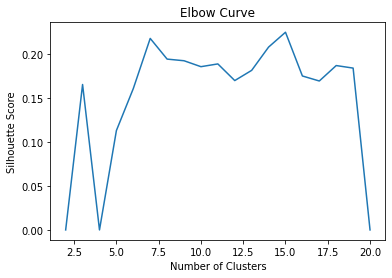

In [30]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate cost and plot
cost = np.zeros(21)

for k in range(2,20):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    cost[k] = evaluator.evaluate(predictions)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [31]:
df_cost

,cluster,cosine
0,2,0.000000
1,3,0.165185
2,4,0.000000
3,5,0.112851
4,6,0.160567
5,7,0.217536
6,8,0.194028
7,9,0.192160
8,10,0.185422
9,11,0.188558


In [63]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|        TEXT_CLEANED|[0.0,0.0,0.0,0.0,...|         0|
|Australia  Manufa...|[0.10912653387485...|         6|
|       CovidVaccine"|[2.06164113988178...|         3|
|CoronavirusVaccin...|[0.71628026647602...|         7|
|Deaths due  COVID...|[0.21943598273795...|         6|
|          Read More |[-0.0427416307450...|         9|
|                   "|[0.0,0.0,0.0,0.0,...|         0|
|   Stay safe  di ...|[0.09849179553245...|        10|
|  This is what pa...|[-0.0467806151252...|         0|
|The Multisystem I...|[0.05905860775814...|         6|
|               The "|[0.0,0.0,0.0,0.0,...|         0|
| Well lets qualif...|[0.16782918070344...|        10|
|Most countries wi...|[0.01495307727972...|        10|
|DNA  zooms up cha...|[0.28030926337175...|        10|
|Biocon Executive ...|[-0.1090836239215...|         9|
|         

In [47]:
predictions.filter("prediction=20").show(50, truncate=False)

+----+--------+----------+
|text|features|prediction|
+----+--------+----------+
+----+--------+----------+

